# AeroBuildup Aerodynamics Engine

## Overview

In order to support conceptual-stage aircraft design optimization, AeroSandbox includes a rapid, vectorized aerodynamics engine called AeroBuildup. AeroBuildup's methodology essentially uses a workbook-style buildup to compute aerodynamic forces, moments, and (optionally) stability derivatives. **It attempts to model viscous and compressible effects on wings and fuselages across any orientation (360 degrees of $\alpha, \beta$) and arbitrary angular rates ($p, q, r$)**.

Obviously, it will be most accurate for semi-realistic flight conditions where theory is sound and experimental data is widely available. (In other words, analyzing an airplane at $\alpha = 90^\circ, M_\infty=1.00$, and huge angular rates will get you an answer that's roughly order-of-magnitude correct, but that's about it.)

Its formulation is largely inspired by the [USAF Digital DATCOM](https://en.wikipedia.org/wiki/United_States_Air_Force_Stability_and_Control_Digital_DATCOM), which was a "best-practices" rapid aeroprediction tool that combined hundreds of theoretical and empirical models across a wide variety of flight regimes. Many aerodynamic submodels are indeed directly shared with Digital DATCOM.

Compared to Digital DATCOM, AeroBuildup has several advantages and limitations.

## Usage

AeroBuildup needs two things:

- An airplane to analyze, which is represented by an `asb.Airplane` object.
- An aerodynamic flight condition to analyze, which is represented by an `asb.OperatingPoint` object.

Let's create an airplane to analyze. First, we'll import the AeroSandbox library:

In [1]:
import aerosandbox as asb
import aerosandbox.numpy as np

Next, we create the airfoils that we want to use in our airplane:

In [2]:
wing_airfoil = asb.Airfoil("sd7037")
tail_airfoil = asb.Airfoil("naca0010")

Now, we can create the airplane. We'll create a simple glider with a main wing, a horizontal tail, and a vertical tail. We'll also translate the horizontal and vertical tails to their correct locations.

In [3]:
### Define the 3D geometry you want to analyze/optimize.
# Here, all distances are in meters and all angles are in degrees.
airplane = asb.Airplane(
    name="Peter's Glider",
    xyz_ref=[0, 0, 0],  # CG location
    wings=[
        asb.Wing(
            name="Main Wing",
            symmetric=True,  # Should this wing be mirrored across the XZ plane?
            xsecs=[  # The wing's cross ("X") sections
                asb.WingXSec(  # Root
                    xyz_le=[0, 0, 0],  # Coordinates of the XSec's leading edge, relative to the wing's leading edge.
                    chord=0.18,
                    twist=2,  # degrees
                    airfoil=wing_airfoil,  # Airfoils are blended between a given XSec and the next one.
                ),
                asb.WingXSec(  # Mid
                    xyz_le=[0.01, 0.5, 0],
                    chord=0.16,
                    twist=0,
                    airfoil=wing_airfoil,
                ),
                asb.WingXSec(  # Tip
                    xyz_le=[0.08, 1, 0.1],
                    chord=0.08,
                    twist=-2,
                    airfoil=wing_airfoil,
                ),
            ]
        ),
        asb.Wing(
            name="Horizontal Stabilizer",
            symmetric=True,
            xsecs=[
                asb.WingXSec(  # root
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=-10,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(  # tip
                    xyz_le=[0.02, 0.17, 0],
                    chord=0.08,
                    twist=-10,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.06]),
        asb.Wing(
            name="Vertical Stabilizer",
            symmetric=False,
            xsecs=[
                asb.WingXSec(
                    xyz_le=[0, 0, 0],
                    chord=0.1,
                    twist=0,
                    airfoil=tail_airfoil,
                ),
                asb.WingXSec(
                    xyz_le=[0.04, 0, 0.15],
                    chord=0.06,
                    twist=0,
                    airfoil=tail_airfoil
                )
            ]
        ).translate([0.6, 0, 0.07])
    ],
    fuselages=[
        asb.Fuselage(
            name="Fuselage",
            xsecs=[
                asb.FuselageXSec(
                    xyz_c=[0.8 * xi - 0.1, 0, 0.1 * xi - 0.03],
                    radius=0.6 * asb.Airfoil("dae51").local_thickness(x_over_c=xi)
                )
                for xi in np.cosspace(0, 1, 30)
            ]
        )
    ]
)

And, we can visualize it:

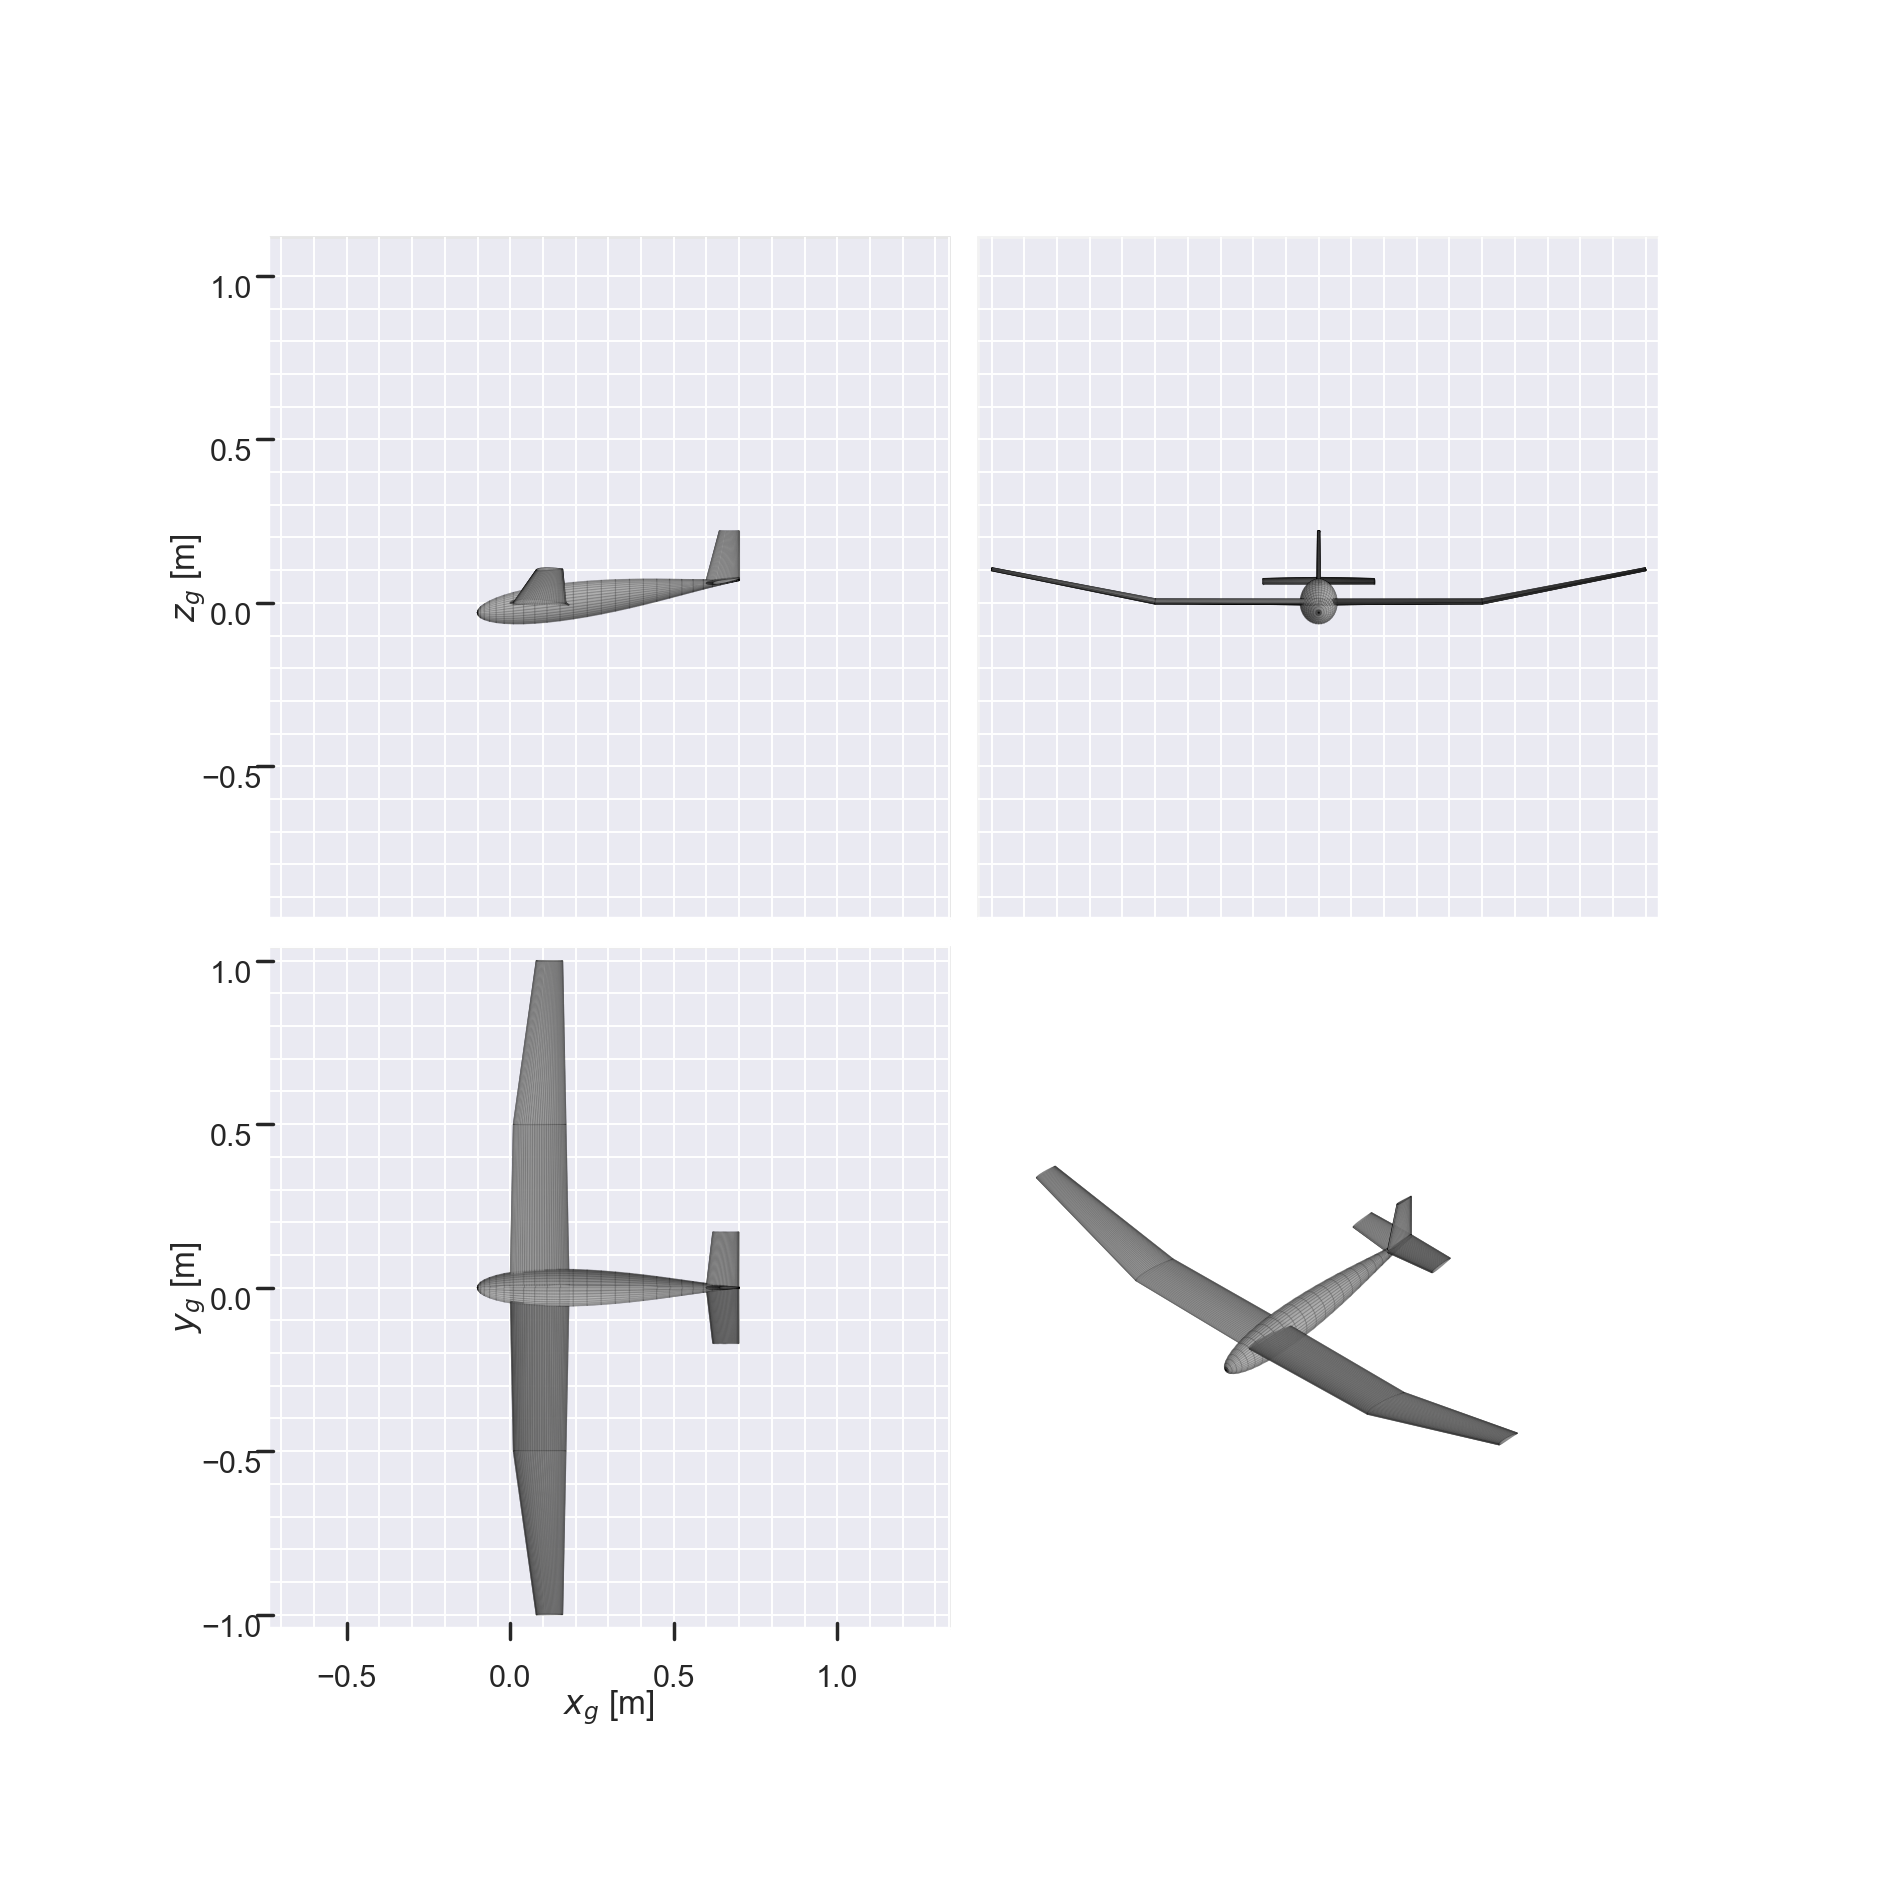

In [4]:
airplane.draw_three_view()

Now, we can use AeroSandbox AeroBuildup to analyze the aerodynamics.

In [5]:
aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=10,
        alpha=5,
    ),
).run()

aero

{'F_g': [array([-0.53546507]), array([-4.62218918e-17]), array([13.81298466])],
 'M_g': [array([6.20966167e-18]),
  array([-0.54812536]),
  array([-2.69069838e-17])],
 'M_b': [array([-6.20966167e-18]),
  array([-0.54812536]),
  array([2.69069838e-17])],
 'M_w': [array([-3.84093387e-18]),
  array([-0.54812536]),
  array([2.73458023e-17])],
 'F_b': (array([0.53546507]), array([-4.62218918e-17]), array([-13.81298466])),
 'F_w': (array([-0.67045348]),
  array([-4.62218918e-17]),
  array([-13.80709093])),
 'L': array([13.80709093]),
 'Y': array([-4.62218918e-17]),
 'D': array([0.67045348]),
 'l_b': array([-6.20966167e-18]),
 'm_b': array([-0.54812536]),
 'n_b': array([2.69069838e-17]),
 'CL': array([0.77099677]),
 'CY': array([-2.58105994e-18]),
 'CD': array([0.03743855]),
 'Cl': array([-1.7167531e-19]),
 'Cm': array([-0.20263751]),
 'Cn': array([7.43883489e-19])}

This gives all the data we'd expect:
- Force vectors and moment vectors, in various reference frames: geometry axes (`F_g` and `M_g`), body axes (`F_b` and `M_b`), and wind axes (`F_w` and `M_w`).
- All the other entries are essentially breakouts of the force and moment vectors into their components, in both dimensional (e.g., "L") and nondimensional (e.g., "CL") forms.
    - Note that the reference quantities for nondimensional coefficients are taken from `airplane.s_ref`, `airplane.c_ref`, and `airplane.b_ref`. These can be specified manually when instantiating the `Airplane` object, but if they aren't, they'll be automatically calculated from the geometry of the airplane's first wing object (found in `asb.Airplane.wings`, which is a list of `asb.Wing` objects).

You can also vectorize AeroBuildup across OperatingPoints - in other words, you can evaluate many different operating points at once. Let's use that feature to generate some lift and drag polars for the entire (3D) airplane:

In [6]:
alpha = np.linspace(-20, 20, 300)

aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=10,
        alpha=alpha,
        beta=0
    ),
).run()

And, let's plot it:

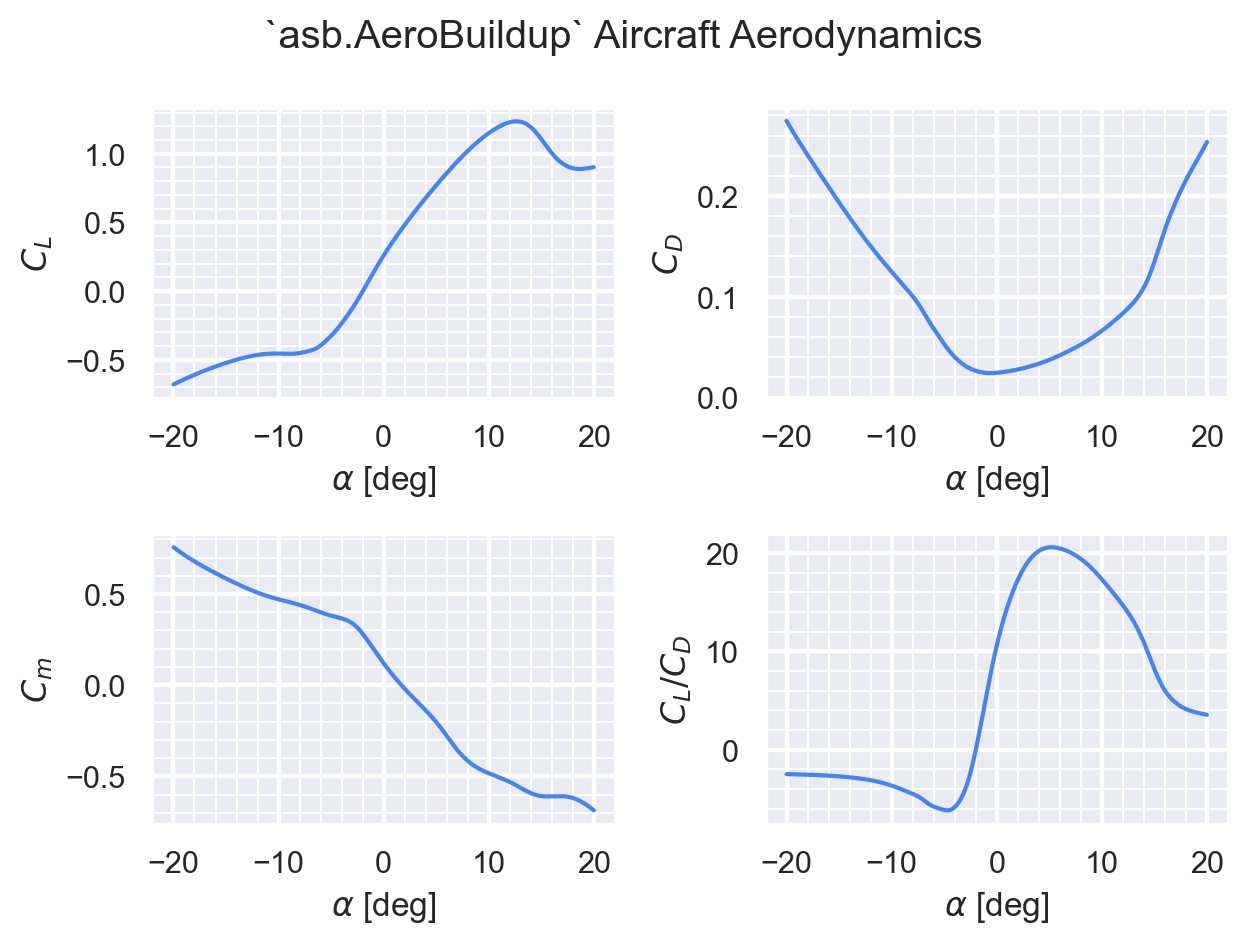

In [7]:
import matplotlib.pyplot as plt
import aerosandbox.tools.pretty_plots as p

fig, ax = plt.subplots(2, 2)

plt.sca(ax[0, 0])
plt.plot(alpha, aero["CL"])
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$C_L$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[0, 1])
plt.plot(alpha, aero["CD"])
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$C_D$")
p.set_ticks(5, 1, 0.05, 0.01)
plt.ylim(bottom=0)

plt.sca(ax[1, 0])
plt.plot(alpha, aero["Cm"])
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$C_m$")
p.set_ticks(5, 1, 0.5, 0.1)

plt.sca(ax[1, 1])
plt.plot(alpha, aero["CL"] / aero["CD"])
plt.xlabel(r"$\alpha$ [deg]")
plt.ylabel(r"$C_L/C_D$")
p.set_ticks(5, 1, 10, 2)

p.show_plot(
    "`asb.AeroBuildup` Aircraft Aerodynamics"
)


Note that `AeroBuildup` is designed to return aerodynamic data from *any* flight condition, even some wacky ones (like 90° sideslip). For example, let's plot the aerodynamics of our glider across a huge alpha and beta range:

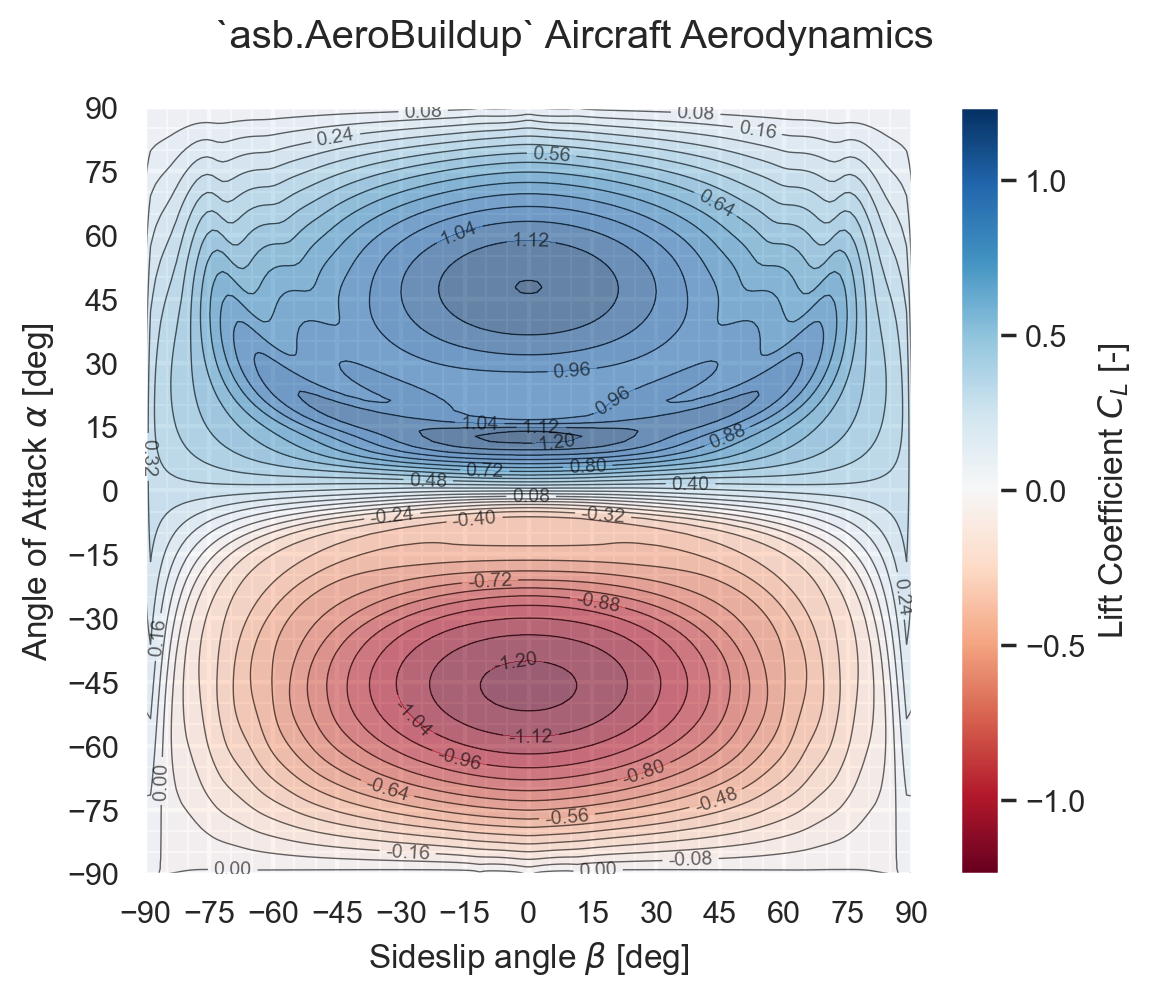

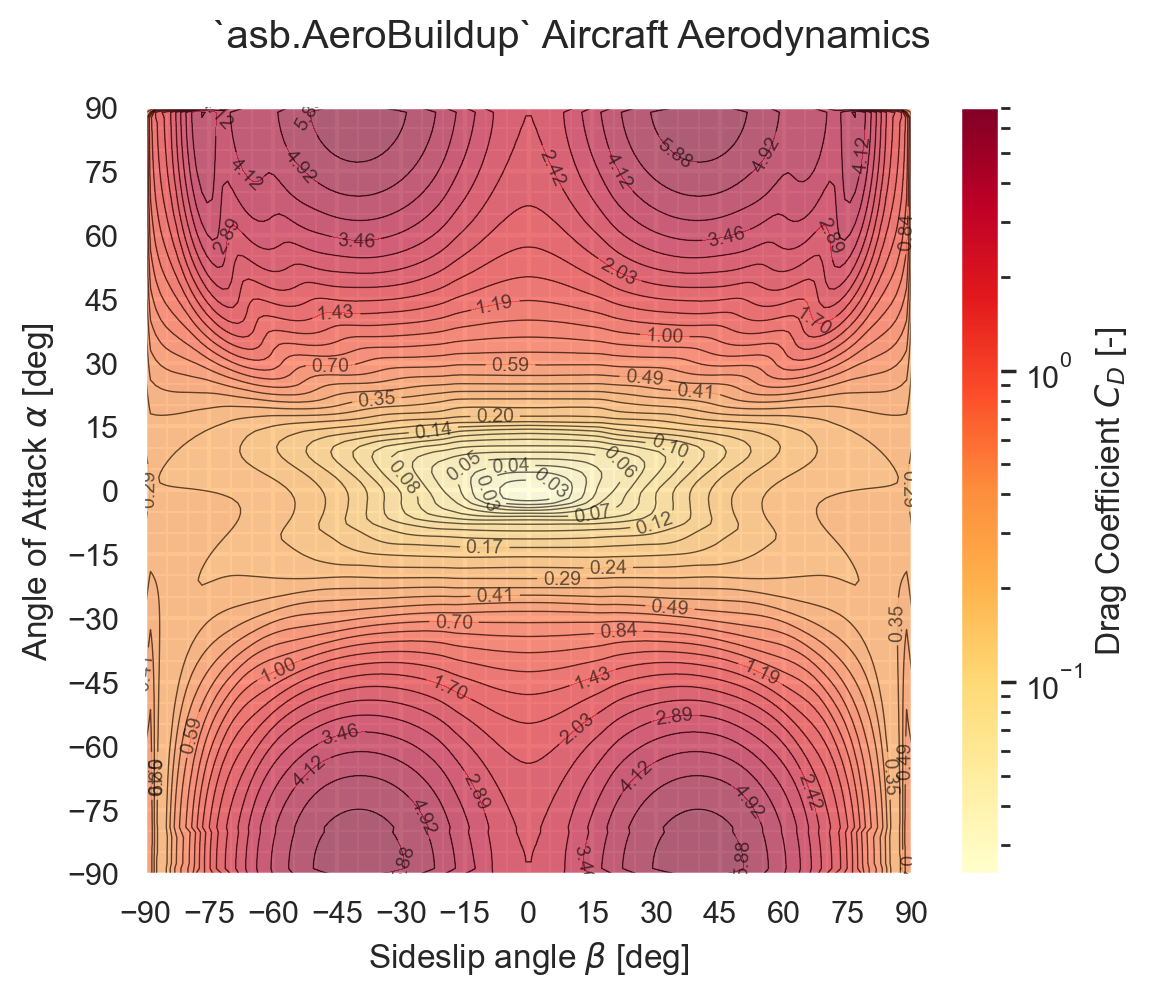

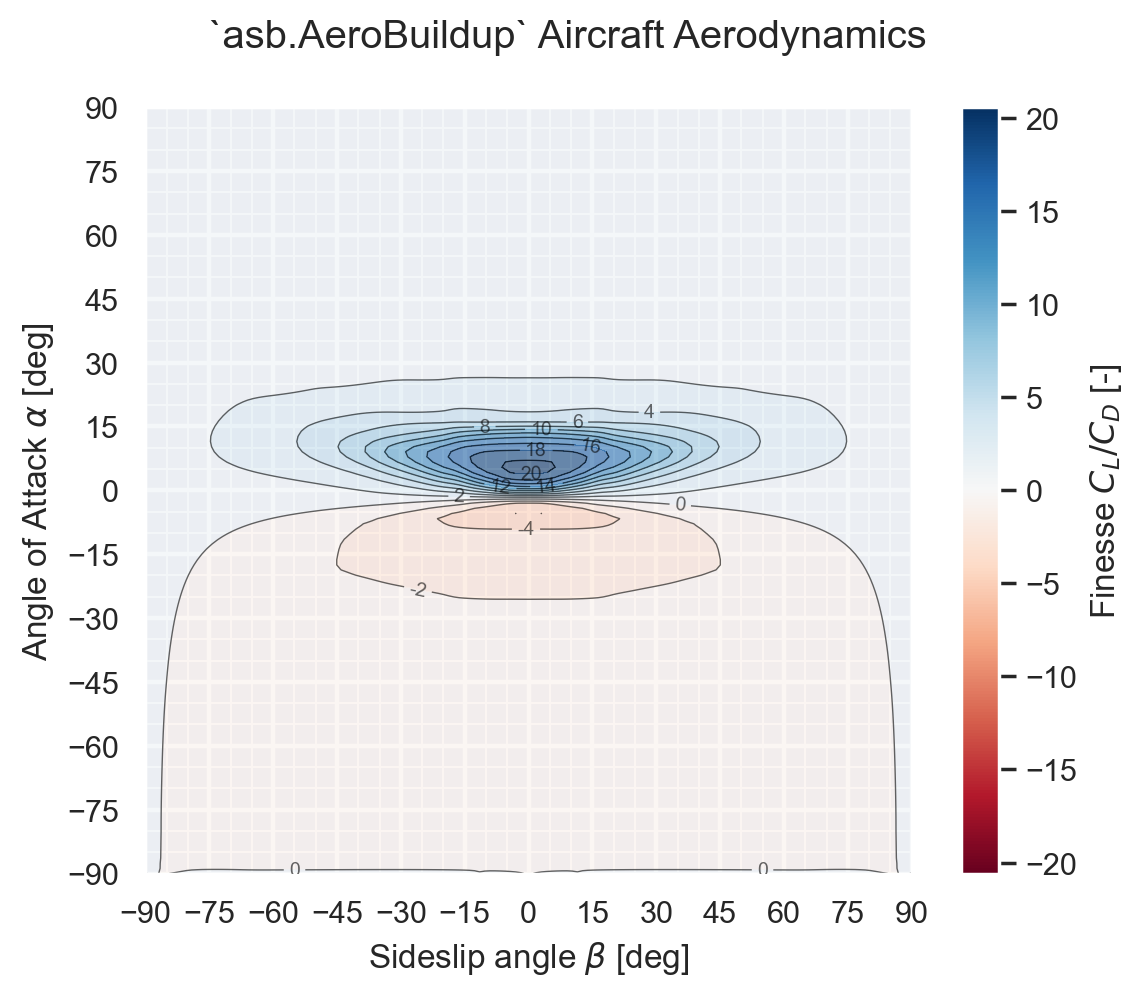

In [9]:
Beta, Alpha = np.meshgrid(np.linspace(-90, 90, 150), np.linspace(-90, 90, 150))
aero = asb.AeroBuildup(
    airplane=airplane,
    op_point=asb.OperatingPoint(
        velocity=10,
        alpha=Alpha.flatten(),
        beta=Beta.flatten()
    ),
).run()


def show():
    p.set_ticks(15, 5, 15, 5)
    p.equal()
    p.show_plot(
        "`asb.AeroBuildup` Aircraft Aerodynamics",
        r"Sideslip angle $\beta$ [deg]",
        r"Angle of Attack $\alpha$ [deg]",
        set_ticks=False
    )


fig, ax = plt.subplots(figsize=(6, 5))
p.contour(
    Beta, Alpha, aero["CL"].reshape(Alpha.shape),
    colorbar_label="Lift Coefficient $C_L$ [-]",
    linelabels_format=lambda x: f"{x:.2f}",
    linelabels_fontsize=7,
    cmap="RdBu",
    alpha=0.6
)
plt.clim(*np.array([-1, 1]) * np.max(np.abs(aero["CL"])))
show()

fig, ax = plt.subplots(figsize=(6, 5))
p.contour(
    Beta, Alpha, aero["CD"].reshape(Alpha.shape),
    colorbar_label="Drag Coefficient $C_D$ [-]",
    linelabels_format=lambda x: f"{x:.2f}",
    linelabels_fontsize=7,
    z_log_scale=True,
    cmap="YlOrRd",
    alpha=0.6
)
show()

fig, ax = plt.subplots(figsize=(6, 5))
p.contour(
    Beta, Alpha, (aero["CL"] / aero["CD"]).reshape(Alpha.shape),
    levels=15,
    colorbar_label="Finesse $C_L / C_D$ [-]",
    linelabels_format=lambda x: f"{x:.0f}",
    linelabels_fontsize=7,
    cmap="RdBu",
    alpha=0.6
)
plt.clim(*np.array([-1, 1]) * np.max(np.abs(aero["CL"] / aero["CD"])))
show()

This shows a much wider perspective on 3D aerodynamics than the standard polars we showed previously (which only showed a small angle of attack range).

## Other Notes

- AeroBuildup models fuselage aerodynamics, so these are included. For more details, see the following tutorial, which covers methodology.
- AeroBuildup models transonic and supersonic effects. However, expect reduced accuracy here, especially in the transonic regime.
- AeroBuildup models the effect of control surfaces, which can be declared by adding `asb.ControlSurface` objects to the `asb.WingXSec` objects within each `asb.Wing` object.